<a href="https://colab.research.google.com/github/cathemesquita/Colab_notebooks/blob/main/PROJETO__ESTRESSE_PHASE_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


> # BIBLIOTECAS

In [ ]:
from IPython.display import clear_output

In [ ]:
! pip install open-ephys-python-tools

clear_output()

In [ ]:
! pip install pactools
clear_output()

In [ ]:
! pip install emd
clear_output()

In [ ]:
from open_ephys.analysis import Session

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import numpy as np
import pandas as pd
import emd
import scipy as sp
from scipy import signal
import math
from scipy.signal import welch, spectrogram, coherence, find_peaks, firwin, lfilter, filtfilt, hilbert
import seaborn as sn

from statsmodels.tsa.stattools import grangercausalitytests
from scipy import stats
from scipy.stats import wilcoxon

import math
import time as ttime
from numpy.fft import fft, ifft, rfft, fftfreq
from scipy.signal import firwin, lfilter, filtfilt
from scipy.io import loadmat
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pactools
from pactools import Comodulogram, REFERENCES

import seaborn as sns

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

> # FUNÇÕES



In [ ]:
def preview(path):
  load = Session(path).recordnodes[0].recordings[0]
  t_raw= load.continuous[0].timestamps
  t = t_raw-t_raw[0]

  data = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t)))

  srate = 1000
  fc_low = 59
  fc_high = 61
  order = 5
  b, a = signal.butter(order, [fc_low/(0.5*srate), fc_high/(0.5*srate)], btype='bandstop')

  data_filt = signal.filtfilt(b, a, data)

  return (pd.DataFrame(data_filt))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def preview_plot(data):

  for i in range(0,32):
    plt.figure()
    plt.plot(data[i])
    plt.title('ch' + str (i+1))

In [ ]:
# CARREGAR O DADO E EXTRAIR MOMENTOS DE IMOBILIDADE

def load_data(path,inicio,final,ch_prl,ch_ca1d,ch_ca1v,ch_bla):
  load = Session(path).recordnodes[0].recordings[0]
  t_raw= load.continuous[0].timestamps
  t = t_raw-t_raw[0]

  # tive que ecolher esse len pq o CCM559 tinha 30 min de dado, então padronizei p todos 10min
  data_prl = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[inicio:final,int(int(ch_prl)-1)]
  data_bla = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[inicio:final,int(int(ch_bla)-1)]
  data_ca1d = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[inicio:final,int(int(ch_ca1d)-1)]
  data_ca1v = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[inicio:final,int(int(ch_ca1v)-1)]


  srate = 1000
  fc_low = 59
  fc_high = 61
  order = 5
  b, a = signal.butter(order, [fc_low/(0.5*srate), fc_high/(0.5*srate)], btype='bandstop')

  PRL = signal.filtfilt(b, a, data_prl)
  BLA = signal.filtfilt(b, a, data_bla)
  CA1D = signal.filtfilt(b, a, data_ca1d)
  CA1V = signal.filtfilt(b, a, data_ca1v)


  return(pd.DataFrame({'data_PRL': PRL,'data_BLA': BLA, 'data_dhpc': CA1D, 'data_vhpc': CA1V}))

In [ ]:
def media_coherence(df, condicao, r1, r2, grupo):
    filtro = (df['condicao'] == condicao) & (df['r1'] == r1) & (df['r2'] == r2) & (df['grupo'] == grupo)
    media_coherence = df[filtro].groupby('animal')['coherence'].mean()
    result_df = pd.DataFrame({'coherence': media_coherence,'r1': r1,'r2': r2,'condicao': condicao,'grupo': grupo})
    return result_df

In [ ]:
# Função para mapear o valor da frequencia da coerencia para o nome da banda
def mapear_banda(valor):
    if 0 <= valor <= 4:
        return 'Delta'
    elif 5 <= valor <= 10:
        return 'Theta'
    elif 11 <= valor <= 29:
        return 'Alpha/beta'
    elif 30 <= valor <= 50:
        return 'Low gamma'
    elif 51 <= valor <= 90:
        return 'Mid gamma'
    else:
        return 'High gamma'

In [ ]:
def load_acelerometer(path):
    load = Session(path).recordnodes[0].recordings[0]
    t_raw = load.continuous[0].timestamps
    t = t_raw - t_raw[0]

    x = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:, 32]
    y = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:, 33]
    z = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:, 34]

    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    acel = np.abs(np.sqrt(x**2 + y**2 + z**2))

    df_acel = pd.DataFrame({'acel': acel})
    df_acel['animal'] = str(rato)
    df_acel['condicao'] = str(condicao)

    return df_acel

In [ ]:
def group_consecutive_numbers(num_list):
    groups = []  # Lista para armazenar os grupos de números consecutivos
    current_group = [num_list[0]]  # Inicializando o primeiro grupo com o primeiro número

    # Iterando sobre a lista de números a partir do segundo elemento
    for num in num_list[1:]:
        if num == current_group[-1] + 1:  # Verificando se o número é consecutivo
            current_group.append(num)  # Se for, adiciona ao grupo atual
        else:
            groups.append(current_group)  # Se não, salva o grupo atual
            current_group = [num]  # Começa um novo grupo

    # Adicionando o último grupo se ele não estiver vazio
    if current_group:
        groups.append(current_group)

    return groups

In [ ]:

# Identificar os grupos de índices consecutivos não-NaN e seus comprimentos para cortar momentos de imobilidade menores que 2s
def find_consecutive_groups(arr):
    # Encontrar as mudanças de NaN para não-NaN e vice-versa
    diff = np.diff(np.isnan(arr).view(np.int8))
    idx, = diff.nonzero()

    # Adicionar o índice do primeiro e último elemento
    idx = np.r_[0, idx + 1, len(arr)]
    idx_pairs = zip(idx[:-1], idx[1:])  # Formar pares de índices

    return [(start, end) for start, end in idx_pairs if not np.isnan(arr[start])]

In [ ]:
def concatenar_listas(lista_de_listas):
    """Concatena uma lista de listas em uma única lista.

    Returns:
   Uma única lista com todos os elementos das sub-listas.
    """
    return [item for sublist in lista_de_listas for item in sublist]

In [ ]:
def load_data_full(path,ch_prl,ch_bla,ch_dhpc, ch_vhpc):
  load = Session(path).recordnodes[0].recordings[0]
  t_raw= load.continuous[0].timestamps
  t = t_raw-t_raw[0]

  # tive que ecolher esse len pq o CCM559 tinha 30 min de dado, então padronizei p todos 10min
  data_prl = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch_prl)-1)]
  data_bla = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch_bla)-1)]
  data_dhpc = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch_dhpc)-1)]
  data_vhpc = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch_vhpc)-1)]

  srate = 1000
  fc_low = 59
  fc_high = 61
  order = 5
  b, a = signal.butter(order, [fc_low/(0.5*srate), fc_high/(0.5*srate)], btype='bandstop')

  PRL = signal.filtfilt(b, a, data_prl)
  BLA = signal.filtfilt(b, a, data_bla)
  dHPC = signal.filtfilt(b, a, data_dhpc)
  vHPC = signal.filtfilt(b, a, data_vhpc)

  return(pd.DataFrame({'data_PRL': PRL,'data_BLA': BLA, 'data_DHPC': dHPC, 'data_VHPC': vHPC}))

In [ ]:
def data_slicing_imovel( rato, condicao ): #cria lista que contém os momentos de imobilidade

  path = ratos[str(rato)]['condicao'][str(condicao)]

  ch_prl =  ratos[rato]['canais']['prl']
  ch_bla =  ratos[rato]['canais']['bla']
  ch_dhpc =  ratos[rato]['canais']['dhpc']
  ch_vhpc =  ratos[rato]['canais']['vhpc']

  load = Session(path).recordnodes[0].recordings[0]
  t_raw= load.continuous[0].timestamps
  t = t_raw-t_raw[0]

  data_prl = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch_prl)-1)]
  data_bla = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch_bla)-1)]
  data_dhpc = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch_dhpc)-1)]
  data_vhpc = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch_vhpc)-1)]

  srate = 1000
  fc_low = 59
  fc_high = 61
  order = 5
  b, a = signal.butter(order, [fc_low/(0.5*srate), fc_high/(0.5*srate)], btype='bandstop')

  PRL = signal.filtfilt(b, a, data_prl)
  BLA = signal.filtfilt(b, a, data_bla)
  dHPC = signal.filtfilt(b, a, data_dhpc)
  vHPC = signal.filtfilt(b, a, data_vhpc)

  # Recuperando dado da acelerometria para definir momentos de atividade
  data_acel = df_acel[(df_acel['animal'] == str(rato)) & (df_acel['condicao'] == str(condicao))]['acel']

  acel = np.array(data_acel)
  acel = np.diff(acel, axis = 0)
  acel = abs(pd.DataFrame(acel)).rolling(window=1000).mean()

  # array booleano dizendo onde animal mexeu e não mexeu
  parado_bool = np.array(acel <= 0.005 )

  index_parado_all = []
  for x in range(len(parado_bool)):
      if parado_bool[x] == True:
        index_parado_all.append(x)

  group_index_parado = group_consecutive_numbers(index_parado_all) #essa função irá agrupar números que são consecutivos em listas separadas

  index_parado = []

  for i in range(len(group_index_parado)): #esse for está selecionando apenas as listas que tem mais de 2s de dado
    if len(group_index_parado[i]) > 2000:
      index_parado.append(group_index_parado[i])

  PRL_cut = [] # ESSA LISTA VAI CONTER OS MOMENTOS DE IMOBILIDADE DO RATO CORRESPONDENTE (ela que será concatenada)

  for i in range(len(index_parado)):
      inicio = index_parado[i][0]
      final = index_parado[i][-1]

      PRL_cut.append(PRL[inicio:final])

  BLA_cut = []

  for i in range(len(index_parado)):
      inicio = index_parado[i][0]
      final = index_parado[i][-1]

      BLA_cut.append(BLA[inicio:final])

  dHPC_cut = []

  for i in range(len(index_parado)):
      inicio = index_parado[i][0]
      final = index_parado[i][-1]

      dHPC_cut.append(dHPC[inicio:final])

  vHPC_cut = []

  for i in range(len(index_parado)):
      inicio = index_parado[i][0]
      final = index_parado[i][-1]

      vHPC_cut.append(vHPC[inicio:final])

  return PRL_cut, BLA_cut, dHPC_cut, vHPC_cut

In [ ]:
# def data_slicing_ativo( rato, condicao ): #cria lista que contém os momentos de atividade

#   path = ratos[str(rato)]['condicao'][str(condicao)]

#   ch_prl =  ratos[rato]['canais']['prl']
#   ch_cg =  ratos[rato]['canais']['cg']
#   ch_il =  ratos[rato]['canais']['il']

#   load = Session(path).recordnodes[0].recordings[0]
#   t_raw= load.continuous[0].timestamps
#   t = t_raw-t_raw[0]

#   data_prl = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch_prl)-1)]
#   data_cg = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch_cg)-1)]
#   data_il = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch_il)-1)]

#   srate = 1000
#   fc_low = 59
#   fc_high = 61
#   order = 5
#   b, a = signal.butter(order, [fc_low/(0.5*srate), fc_high/(0.5*srate)], btype='bandstop')

#   PRL = signal.filtfilt(b, a, data_prl)
#   ACC = signal.filtfilt(b, a, data_cg)
#   IL = signal.filtfilt(b, a, data_il)

#   # Recuperando dado da acelerometria para definir momentos de atividade
#   data_acel = df_acel[(df_acel['animal'] == str(rato)) & (df_acel['condicao'] == str(condicao))]['acel']

#   acel = np.array(data_acel)
#   acel = np.diff(acel, axis = 0)
#   acel = abs(pd.DataFrame(acel)).rolling(window=1000).mean()

#   # array booleano dizendo onde animal mexeu e não mexeu
#   ativo_bool = np.array(acel >= 0.005 )

#   index_ativo_all = []
#   for x in range(len(ativo_bool)):
#       if ativo_bool[x] == True:
#         index_ativo_all.append(x)

#   group_index_ativo = group_consecutive_numbers(index_ativo_all) #essa função irá agrupar números que são consecutivos em listas separadas

#   index_ativo = []

#   for i in range(len(group_index_ativo)): #esse for está selecionando apenas as listas que tem mais de 2s de dado
#     if len(group_index_ativo[i]) > 2000:
#       index_ativo.append(group_index_ativo[i])

#   PRL_cut = [] # ESSA LISTA VAI CONTER OS MOMENTOS DE IMOBILIDADE DO RATO CORRESPONDENTE (ela que será concatenada)

#   for i in range(len(index_ativo)):
#       inicio = index_ativo[i][0]
#       final = index_ativo[i][-1]

#       PRL_cut.append(PRL[inicio:final])

#   ACC_cut = []

#   for i in range(len(index_ativo)):
#       inicio = index_ativo[i][0]
#       final = index_ativo[i][-1]

#       ACC_cut.append(ACC[inicio:final])

#   IL_cut = []

#   for i in range(len(index_ativo)):
#       inicio = index_ativo[i][0]
#       final = index_ativo[i][-1]

#       IL_cut.append(IL[inicio:final])

#   return PRL_cut, ACC_cut, IL_cut

In [ ]:
def get_psd( data_psd  ):

  f, p = welch(data_psd, fs = 1000,nperseg = 1000, noverlap = int(0.9*1000), nfft = 10*1000)
  df_psd = pd.DataFrame({'PSD': p, 'F': f})

  return(df_psd )

In [ ]:
def tempo_para_pontos(tempo):
    minutos, segundos = map(int, tempo.split(':'))
    total_segundos = minutos * 60 + segundos
    pontos = total_segundos * 1000
    return pontos

In [ ]:
def bandpass(data, cutfreq, filtorder, sampling_rate):

        fny = sampling_rate/2

        b, a = signal.butter(N = filtorder, Wn=np.array(cutfreq) / fny,
                                         btype='bandpass')
        dataout = signal.filtfilt(b, a, data)

        return dataout

In [ ]:
# FILTRO SIMPLES

def eegfilt(data,srate,flow,fhigh):

    # fir LS
    trans = 0.15
    nyq = srate*0.5
    f=[0, (1-trans)*flow/nyq, flow/nyq, fhigh/nyq, (1+trans)*fhigh/nyq, 1]
    m=[0,0,1,1,0,0]
    filt_order = 3*np.fix(srate/flow)
    if filt_order % 2 == 0:
        filt_order = filt_order + 1

    filtwts = signal.firls(filt_order,f,np.double(m))
    data_filt = signal.filtfilt(filtwts,1, data)

    return(data_filt)


In [ ]:
#ExTRAINDO O MODULATION INDEX

def modulation_index(amp,fase_lenta,numbin):

    position=np.zeros(numbin) # this variable will get the beginning (not the center) of each phase bin (in rads)
    winsize = 2*np.pi/numbin # bin de fase

    position = []
    for j in np.arange(1,numbin+1):
        position.append(-np.pi+(j-1)*winsize)

    nbin=numbin
    mean_amp = []
    for j in np.arange(0,nbin):
        boolean_array = np.logical_and(fase_lenta >=  position[j], fase_lenta < position[j]+winsize)
        I = np.where(boolean_array)[0]
        mean_amp.append(np.mean(amp[I]))

    mean_amp = [x for x in mean_amp if str(x) != 'nan']
    p = mean_amp/np.sum(mean_amp)

    entrop = -1*(np.sum(p*np.log(p)))
    mi = (np.log(numbin)-entrop)/np.log(numbin)

    return(mi)

In [ ]:
# ACOP FASE AMPL PARA UMA REGIÃO

def pac(lfp,lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,srate,numbin):

    AmpFreqTransformed1 = []
    PhaseFreq = []

    pac_mi = []

    for ii in altaVector:
        Af1 = ii
        Af2=Af1+alta_BandWidth

        AmpFreq1=eegfilt(lfp,srate,Af1,Af2) # just filtering

        analytic_signal1 = signal.hilbert(AmpFreq1)
        AmpFreqTransformed1.append(np.abs(analytic_signal1))

    faselenta = []
    for jj in lentaVector:
        Pf1 = jj
        Pf2 = Pf1 + lenta_BandWidth
        PhaseFreq=eegfilt(lfp,srate,Pf1,Pf2)
        analytic_signal = signal.hilbert(PhaseFreq)
        faselenta.append(np.angle(analytic_signal))

    fase_lenta = faselenta

    comodulogram = np.empty((len(lentaVector),len(altaVector)))

    for count_lenta,lenta in enumerate(fase_lenta):

        for count_rapida,rapida in enumerate(AmpFreqTransformed1):

            comodulogram[count_lenta,count_rapida] = modulation_index(rapida,lenta,numbin)


    return(comodulogram)

In [ ]:
# ACOP FASE AMPL ENTRE DUAS REGIÕES

def pac_entre_regioes(lfp_alta,lfp_lenta,lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,srate,numbin):

    AmpFreqTransformed1 = []
    PhaseFreq = []

    pac_mi = []

    for ii in altaVector:
        Af1 = ii
        Af2=Af1+alta_BandWidth

        AmpFreq1=eegfilt(lfp_alta,srate,Af1,Af2) # just filtering

        analytic_signal1 = signal.hilbert(AmpFreq1)
        AmpFreqTransformed1.append(np.abs(analytic_signal1))


    faselenta = []
    for jj in lentaVector:
        Pf1 = jj
        Pf2 = Pf1 + lenta_BandWidth
        PhaseFreq=eegfilt(lfp_lenta,srate,Pf1,Pf2)
        analytic_signal = signal.hilbert(PhaseFreq)
        faselenta.append(np.angle(analytic_signal))


    fase_lenta = faselenta

    comodulogram = np.empty((len(lentaVector),len(altaVector)))


    for count_lenta,lenta in enumerate(fase_lenta):

        for count_rapida,rapida in enumerate(AmpFreqTransformed1):

            comodulogram[count_lenta,count_rapida] = modulation_index(rapida,lenta,numbin)


    return(comodulogram)

In [ ]:
# Causalidade de granger

def grangercausality(data1,data2,r1, r2, condicao, rato,frate,flow,fhigh):

  envelope_data_1 = np.abs(signal.hilbert(eegfilt(data1,frate,flow,fhigh)))
  test_data_1 = np.squeeze(envelope_data_1)

  envelope_data_2 = np.abs(signal.hilbert(eegfilt(data2,frate,flow,fhigh)))
  test_data_2 = np.squeeze(envelope_data_2)

  matrix_test = np.vstack([np.diff(test_data_1),np.diff(test_data_2)]).T
  lag = [int(math.sqrt(len(matrix_test)))]
  gc = grangercausalitytests(matrix_test,lag,verbose = False)
  results_test_r = [gc[lag[0]][0]['ssr_ftest'][1],gc[lag[0]][0]['ssr_ftest'][0]]

  p_label = []
  p = results_test_r[0]
  if p <= 0.01:
    p_label.append('p<0.01')
  elif 0.01 < p < 0.05:
    p_label.append('p<0.05')
  elif p == 0.05:
    p_label.append('p=0.05')
  else:
    p_label.append('p>0.05')

  df_granger = pd.DataFrame({ 'Granger Causality':  results_test_r[1], 'P value': p_label, 'r1': r1, 'r2': r2, 'condicao': condicao}, index=['Results'])

  return(df_granger )

In [ ]:

def phase_amp_hist(amp,fase_lenta,numbin):

    position=np.zeros(numbin) # this variable will get the beginning (not the center) of each phase bin (in rads)
    winsize = 2*np.pi/numbin # bin de fase

    position = []
    for j in np.arange(1,numbin+1):
        position.append(-np.pi+(j-1)*winsize)


    nbin=numbin
    mean_amp = []
    for j in np.arange(0,nbin):
        boolean_array = np.logical_and(fase_lenta >=  position[j], fase_lenta < position[j]+winsize)
        I = np.where(boolean_array)[0]
        mean_amp.append(np.mean(amp[I]))

    mean_amp = [x for x in mean_amp if str(x) != 'nan']
    p = mean_amp/np.sum(mean_amp)

    return(p)


def pac_histogram(lfp_amp,lfp_fase,altaVector,lenta_BandWidth,alta_BandWidth,srate,numbin,mask):

    AmpFreqTransformed1 = []

    for ii in altaVector:
        Af1 = ii
        Af2=Af1+alta_BandWidth

        AmpFreq1=eegfilt(lfp_amp,srate,Af1,Af2) # just filtering

        analytic_signal1 = signal.hilbert(AmpFreq1)
        AmpFreqTransformed1.append(np.abs(analytic_signal1)[mask])

    Pf1 = 4
    Pf2 = 12
    PhaseFreq=eegfilt(lfp_fase,srate,Pf1,Pf2)
    analytic_signal = signal.hilbert(PhaseFreq)
    faselenta = np.angle(analytic_signal)[mask]

    hist_freqs = []

    for count_rapida,rapida in enumerate(AmpFreqTransformed1):

        hist_freqs.append(phase_amp_hist(rapida,faselenta,numbin))


    return(hist_freqs)

> # ANÁLISE DOS DADOS

In [ ]:
# ATENÇÃO: aqui os canais iniciam em 1 e não em 0 (i+1), ou seja, ch1 == ch0, ch32 == ch31....


#'CCM64': { 'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_24_08_2023/GRUPO_ESCAPAVEL/CCM64_OF_PRE_EXP',
                      #              'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_24_08_2023/GRUPO_ESCAPAVEL/CCM64_OF_POS_EXP'},
                      # 'grupo': { 'ESCAPAVEL'},

                      # 'canais': {'prl': 22,
                      #             'cg': 31,
                      #             'il': 25 ,
                      #             'ca1-d': 1 ,
                      #             'ca1-v': 14 ,
                      #             'bla': 19 },

                      # 'inicio': { 'OF_pre': 1000 ,
                      #             'OF_pos': 345000} },  # ESTE ANIMAL ESTÁ SÓ COM 4S DE REGISTRO DE OF POS EXP!!!!!!



          # 'CCM04': { 'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_28_08_2023/GRUPO INESCAPAVEL/CCM04_OF_PRE_EXP',
          #                          'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_28_08_2023/GRUPO INESCAPAVEL/CCM04_OF_POS_EXP'},
          #             'grupo': 'INESCAPAVEL',

          #             'canais': {'prl': 22 ,
          #                         'cg': 29 ,
          #                         'il': 27 ,
          #                         'ca1-d':11 ,
          #                         'ca1-v': 13 ,
          #                         'bla': 19 },

          #             'inicio': { 'OF_pre': 90000  ,
          #                         'OF_pos': 1000 } },   # OF PRE ESTÁ SÓ COM 20000 PONTOS!!!!!!!

ratos = { 'CCM68': { 'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_28_08_2023/GRUPO ESCAPAVEL/CCM68_OF_PRE_EXP',
                                         'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_28_08_2023/GRUPO ESCAPAVEL/CCM68_OF_POS_EXP'},

                      'grupo': 'ESCAPAVEL',

                      'canais': {'prl':31 ,
                                  'cg':23 ,
                                  'il': 27 ,
                                  'dhpc': 1 ,
                                  'vhpc': 12 ,
                                  'bla':20  },

                      'inicio': { 'OF_pre': 270000 ,
                                  'OF_pos': 80000} }, # VERIFICADO OF PRE E POS OK

          'CCM65': { 'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_31_08_2023/GRUPO ESCAPAVEL/CCM65_OF_PRE_EXP',
                                   'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_31_08_2023/GRUPO ESCAPAVEL/CCM65_OF_POS_EXP'},
                      'grupo': 'ESCAPAVEL',

                      'canais': {'prl': 26 ,
                                  'cg': 32 ,
                                  'il': 24 ,
                                  'dhpc': 7 ,
                                  'vhpc': 16,
                                  'bla': 17 },

                      'inicio': { 'OF_pre': 1000  ,
                                  'OF_pos': 360000 } },  # VERIFICADO OF PRE E POS OK

          'CCM191': { 'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_13_10_2023/GRUPO_ESCAPAVEL/CCM191_OF_PRE_EXP',
                                   'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_13_10_2023/GRUPO_ESCAPAVEL/CCM191_OF_POS_EXP'},
                      'grupo': 'ESCAPAVEL',

                      'canais': {'prl': 23,
                                  'cg': 31,
                                  'il': 28 ,
                                  'dhpc': 7 ,
                                  'vhpc': 11 ,
                                  'bla': 13  },

                      'inicio': { 'OF_pre': 20000 ,
                                  'OF_pos': 75000} },  # VERIFICADO OF PRE E POS OK

          'CCM05': { 'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_30_08_2023/GRUPO INESCAPAVEL/CCM05_OF_PRE_EXP',
                                   'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_30_08_2023/GRUPO INESCAPAVEL/CCM05_OF_POS_EXP'},
                      'grupo': 'INESCAPAVEL',

                      'canais': {'prl': 24 ,
                                  'cg': 30,
                                  'il': 28 ,
                                  'dhpc': 6  ,
                                  'vhpc': 12 ,
                                  'bla': 17 },

                      'inicio': { 'OF_pre': 205000 ,
                                  'OF_pos': 265000 } },  # VERIFICADO OF PRE E POS OK

          'CCM192': { 'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_25_10_2023/GRUPO INESCAPAVEL/CCM192_OF_PRE_EXP',
                                   'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_25_10_2023/GRUPO INESCAPAVEL/CCM192_OF_POS_EXP'},
                      'grupo': 'INESCAPAVEL',

                      'canais': {'prl':22 ,
                                  'cg':31 ,
                                  'il': 27 ,
                                  'dhpc':5  ,
                                  'vhpc':12  ,
                                  'bla': 20 },

                      'inicio': { 'OF_pre': 140000 ,
                                  'OF_pos': 170000 } },   # VERIFICADO OF PRE E POS OK



          'CCM193': { 'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_30_10_2023/GRUPO INESCAPAVEL/CCM193_OF_PRE_EXP',
                                   'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_30_10_2023/GRUPO INESCAPAVEL/CCM193_OF_POS_EXP'},
                      'grupo': 'INESCAPAVEL',

                      'canais': {'prl': 23,
                                  'cg': 29,
                                  'il': 25 ,
                                  'dhpc':6  ,
                                  'vhpc': 11 ,
                                  'bla': 19 },

                      'inicio': { 'OF_pre': 1000 ,
                                  'OF_pos': 268000} }}   # VERIFICADO OF PRE E POS OK



In [ ]:
x = preview( '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_25_10_2023/GRUPO INESCAPAVEL/CCM192_OF_PRE_EXP')
# preview_plot(x)

/usr/local/lib/python3.10/dist-packages/open_ephys/analysis/formats/BinaryRecording.py:141: ResourceWarning: unclosed file <_io.TextIOWrapper name='/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_25_10_2023/GRUPO INESCAPAVEL/CCM192_OF_PRE_EXP/Record Node 101/experiment1/recording1/structure.oebin' mode='r' encoding='UTF-8'>
  self.info = json.load(open(os.path.join(self.directory, 'structure.oebin')))


# DATA BASED ON ACELEROMETER

In [ ]:
# calcular o espectro para cada pedacinho separadamente e depois tirar a média de todos os pedacinhos
# colocar o nperseg 2000 (mesmo tamanho do menor fragmento)


# a unidade do plot será: Power Ratio (a.u.)

In [ ]:
# CRIANDO DF COM OS DADOS COMPLETOS

dataframes_full = []
for rato in ratos.keys():
  for condicao in ratos[rato]['condicao'].keys():

      path = ratos[str(rato)]['condicao'][str(condicao)]

      grupo = ratos[rato]['grupo']
      ch_prl =  ratos[rato]['canais']['prl']
      ch_bla = ratos[rato]['canais']['bla']
      ch_dhpc = ratos[rato]['canais']['dhpc']
      ch_vhpc = ratos[rato]['canais']['vhpc']

      df_temp_full = load_data_full(path,ch_prl,ch_bla,ch_dhpc, ch_vhpc)
      df_temp_full['animal'] = str(rato)
      df_temp_full['condicao'] = str(condicao)
      df_temp_full['grupo'] = str(grupo)

      dataframes_full.append(df_temp_full)

df_full = pd.concat(dataframes_full)
clear_output()

In [ ]:
# OBTENDO DADOS DO ACELEROMETRO

data_acel = []

for rato in ratos.keys():
    for condicao in ratos[rato]['condicao'].keys():
        path = ratos[str(rato)]['condicao'][str(condicao)]
        grupo = ratos[rato]['grupo']
        df_temp_acel = load_acelerometer(str(path))
        df_temp_acel['grupo'] = str(grupo)
        data_acel.append(df_temp_acel)

df_acel = pd.concat(data_acel)
clear_output()


In [ ]:
# CORTANDO MOMENTOS DE IMOBILIDADE A PARTIR DO ACELEROMETRO

# ESCAP
PRL_CCM68_PRE_P, BLA_CCM68_PRE_P , dHPC_CCM68_PRE_P, vHPC_CCM68_PRE_P = data_slicing_imovel( 'CCM68', 'OF_pre' ) #ESSA FUNÇÃO PRODUZ LISTAS QUE CONTÉM LISTAS COM MOMENTOS DE IMOBILIDADE POR MAIS DE 2S
PRL_CCM68_POS_P, BLA_CCM68_POS_P , dHPC_CCM68_POS_P, vHPC_CCM68_POS_P = data_slicing_imovel( 'CCM68', 'OF_pos' )

PRL_CCM65_PRE_P, BLA_CCM65_PRE_P , dHPC_CCM65_PRE_P, vHPC_CCM65_PRE_P = data_slicing_imovel( 'CCM65', 'OF_pre' )
PRL_CCM65_POS_P, BLA_CCM65_POS_P , dHPC_CCM65_POS_P, vHPC_CCM65_POS_P = data_slicing_imovel( 'CCM65', 'OF_pos' )

PRL_CCM191_PRE_P, BLA_CCM191_PRE_P , dHPC_CCM191_PRE_P, vHPC_CCM191_PRE_P = data_slicing_imovel( 'CCM191', 'OF_pre' )
PRL_CCM191_POS_P, BLA_CCM191_POS_P , dHPC_CCM191_POS_P, vHPC_CCM191_POS_P = data_slicing_imovel( 'CCM191', 'OF_pos' )


# INESCAP
PRL_CCM05_PRE_P, BLA_CCM05_PRE_P , dHPC_CCM05_PRE_P, vHPC_CCM05_PRE_P = data_slicing_imovel( 'CCM05', 'OF_pre' )
PRL_CCM05_POS_P, BLA_CCM05_POS_P , dHPC_CCM05_POS_P, vHPC_CCM05_POS_P = data_slicing_imovel( 'CCM05', 'OF_pos' )

PRL_CCM192_PRE_P, BLA_CCM192_PRE_P , dHPC_CCM192_PRE_P, vHPC_CCM192_PRE_P = data_slicing_imovel( 'CCM192', 'OF_pre' )
PRL_CCM192_POS_P, BLA_CCM192_POS_P , dHPC_CCM192_POS_P, vHPC_CCM192_POS_P = data_slicing_imovel( 'CCM192', 'OF_pos' )

PRL_CCM193_PRE_P, BLA_CCM193_PRE_P , dHPC_CCM193_PRE_P, vHPC_CCM193_PRE_P = data_slicing_imovel( 'CCM193', 'OF_pre' )
PRL_CCM193_POS_P, BLA_CCM193_POS_P , dHPC_CCM193_POS_P, vHPC_CCM193_POS_P = data_slicing_imovel( 'CCM193', 'OF_pos' )
clear_output()

> # THETA TRACE FILTERED

In [ ]:
# from scipy import signal as sp_signal  # Importa o módulo signal com um alias para evitar conflitos


def basspass(data, cutfreq, filtorder, sampling_rate):

        fny = sampling_rate/2

        b, a = signal.butter(N = filtorder, Wn=np.array(cutfreq) / fny,
                                         btype='bandpass')
        dataout = signal.filtfilt(b, a, data)

        return dataout



theta_fcut = [4, 18]

lfp_PRE = basspass(bla_pre_inescap,  [4, 18], 4, 1000)
# lfp_POS = basspass(bla_pos_inescap, theta_fcut, 4, 1000)

NameError: name 'bla_pre_inescap' is not defined

In [ ]:
plt.plot(lfp_PRE, color = 'darkblue', label = 'Theta filtered')
plt.plot(bla_pre_inescap, color = 'b', label = 'Original')


> # THETA PEAK TRIGGED AVERAGE

In [ ]:

# Identificar os grupos de índices consecutivos não-NaN e seus comprimentos para cortar momentos de imobilidade menores que 2s
def find_consecutive_groups(arr):
    # Encontrar as mudanças de NaN para não-NaN e vice-versa
    diff = np.diff(np.isnan(arr).view(np.int8))
    idx, = diff.nonzero()

    # Adicionar o índice do primeiro e último elemento
    idx = np.r_[0, idx + 1, len(arr)]
    idx_pairs = zip(idx[:-1], idx[1:])  # Formar pares de índices

    return [(start, end) for start, end in idx_pairs if not np.isnan(arr[start])]




def generating_masks(DATA,data_acel,regiao):

  acel = np.array(data_acel)
  acel = np.diff(acel, axis = 0)
  acel = abs(pd.DataFrame(acel)).rolling(window=1000).mean()

  # array booleano dizendo onde animal mexeu e não mexeu
  parado_bool = np.array(acel <= 0.005 )
  parado_bool = np.append(parado_bool, 0) #aqui foi adicionado um 0 pois a função diff retira um elemento do vetor, assim ele volta ao tamanho original

  index_parado_all = []
  index_ativo_all = []

  for x in range(len(parado_bool)):
      if parado_bool[x] == True:
        index_parado_all.append(x)
      elif parado_bool[x] == False:
        index_ativo_all.append(x)

  vector_nan = np.full(len(DATA), np.nan)

  vector_nan[index_parado_all] = DATA[index_parado_all]

  # Essa parte do código irá retirar pedaços muito curtos de dado (menos de 2s)
  groups = find_consecutive_groups(vector_nan)

  for start, end in groups:
      length = end - start
      if length < 2000:
            vector_nan[start:end] = np.nan #transforma pedaços menores que 2s em Nan

  mask_low = np.where(~np.isnan(vector_nan))[0] #pegando apenas os indices dos valores que não são Nan

  vector_nan_high = np.full(len(DATA), np.nan)

  vector_nan_high[index_ativo_all] = DATA[index_ativo_all]


  # Essa parte do código irá retirar pedaços muito curtos de dado (menos de 2s)
  groups_high = find_consecutive_groups(vector_nan_high)

  for start, end in groups_high:
      length_high = end - start
      if length_high < 2000:
            vector_nan_high[start:end] = np.nan #transforma pedaços menores que 2s em Nan

  mask_high = np.where(~np.isnan(vector_nan_high))[0] #pegando apenas os indices dos valores que não são Nan

  return(mask_low, mask_high )

In [ ]:
def do_ta(time_ref, signal_2trigger, ta_winlen):

        time_ref = time_ref[time_ref > ta_winlen//2]
        time_ref = time_ref[time_ref < (len(signal_2trigger) - ta_winlen//2)]
        rel_samples = np.arange(ta_winlen) - ta_winlen//2

        ta_mat = np.zeros((len(time_ref),ta_winlen))
        for ta_win_i in range(0, len(time_ref)):
                win_samples = rel_samples + time_ref[ta_win_i]
                ta_mat[ta_win_i] = signal_2trigger[win_samples]

        ta = np.mean(ta_mat, axis=0)
        return ta, rel_samples

In [ ]:
lfp = dHPC_CCM68_PRE_P[0]
sampling_rate = 1000
gamma_fcut = [90, 150]
gamma = bandpass(lfp, gamma_fcut, 3, sampling_rate)

gamma_hilb = signal.hilbert(gamma)
gamma_env = np.abs(gamma_hilb)

In [ ]:


theta_fcut = [4, 18]
theta = bandpass(lfp, theta_fcut, 3, sampling_rate)

theta_maxf = 12
theta_peaks = signal.find_peaks(theta, height=0, distance=int(sampling_rate/theta_maxf))[0]
time_ref = theta_peaks

In [ ]:
ta_winlen = 200

ta_lfp, rel_samples = do_ta(theta_peaks, lfp, ta_winlen)
ta_gammaenv, rel_samples = do_ta(theta_peaks, gamma_env, ta_winlen)

plt.figure(figsize=(5,3))
plt.subplot(2,1,1)
plt.plot(rel_samples, ta_lfp, color='k', lw=2)
plt.grid(True)
plt.subplot(2,1,2)
plt.plot(rel_samples, ta_gammaenv, color='darkgreen', lw=2)

plt.grid(True)

In [ ]:
def wvfilt(lfp,mfreq,sr=1250., w=5, s=1, normwv=True):

        # computing the length of the wavelet for the desired frequency
        wavelen = int(np.round(2*w*s*sr/mfreq))

        # constructs morlet wavelet with given parameters
        wave = signal.morlet(wavelen,w=w,s=s,complete=True)

        # cutting borders
        cumulativeEnvelope = np.cumsum(np.abs(wave))/np.sum(np.abs(wave))
        Cut1 = next(i for (i,val) in enumerate(cumulativeEnvelope[::-1]) if val<=(1./2000))
        Cut2 = Cut1
        Cut1 = len(cumulativeEnvelope)-Cut1-1
        wave = wave[range(Cut1,Cut2)]

        # normalizes wavelet energy
        if normwv:
                wave = wave/(.5*sum(abs(wave)))

        if (len(wave))>len(lfp):
                print('ERROR: input signal needs at least '+str(len(wave))+\
                                                            ' time points for '+str(mfreq)+\
                                                                      'Hz-wavelet convolution')
                return None

        # convolving signal with wavelet
        fsignal = np.convolve(lfp,wave,'same')
        return fsignal

def wvSpect(lfp,freqs,sampling_rate):
        ''' lfp: array float
            output: spectogram..
        '''

        freqs = np.array(freqs).reshape(-1,1)
        tfr = np.zeros((np.size(freqs),len(lfp)),dtype=complex)
        for (fi,f) in enumerate(freqs):
                f = float(f)
                tfr[fi,:] = wvfilt(lfp,f,sampling_rate)

        output = np.abs(tfr).squeeze()

        return output

In [ ]:
nperseg = sampling_rate * 2
noverlap = nperseg // 2
psd_frqs, psd_t, psd = signal.spectrogram(lfp, fs=sampling_rate, \
                             nperseg=nperseg, noverlap=noverlap, nfft=nperseg, axis=0)

In [ ]:
fmask = (psd_frqs>4)&(psd_frqs<20)
# chi = chis_pfc[1]

plt.figure()
plt.pcolormesh(psd_t, psd_frqs[fmask], psd[fmask], vmax=5000)
plt.colorbar()

# tmask_pre = psd_t<180
# tmask_pos = psd_t>180

# psd_pre = np.mean(psd[fmask][:,tmask_pre], axis=1)
# psd_pos = np.mean(psd[fmask][:,tmask_pos], axis=1)

# plt.figure()
# plt.plot(psd_frqs[fmask], psd_pre, lw=2)
# plt.plot(psd_frqs[fmask], psd_pos, 'r', lw=2)

In [ ]:
theta_hilb = signal.hilbert(theta)
theta_ph = np.angle(theta_hilb)

plt.figure(figsize=(25,5))
plt.subplot(2,1,1)
plt.plot(theta)
plt.subplot(2,1,2)
plt.plot(theta_ph)
plt.grid(True)

> # TESTES

In [ ]:
sample_rate = 1000
imf = emd.sift.iterated_mask_sift(dHPC_CCM68_PRE_P[0], sample_rate=sample_rate)


In [ ]:
ciclos = emd.cycles.get_cycle_vector(IP, return_good=False, mask=None, imf=None, phase_step=4.71238898038469, phase_edge=0.2617993877991494, min_len=2)

In [ ]:

IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')

In [ ]:
# Define frequency range (low_freq, high_freq, nsteps, spacing)
freq_range = (4, 18, 80, 'log')
f, hht = emd.spectra.hilberthuang(IF, IA, freq_range, sum_time=False)

In [ ]:
emd.plotting.plot_imfs(imf)

In [ ]:
good_cycles = emd.cycles.get_cycle_vector(IP, return_good=True, phase_step=np.pi)
all_cycles = emd.cycles.get_cycle_vector(IP, return_good=False)

In [ ]:
# Compute cycle average frequency for all cycles and masked cycles
all_cycle_freq = emd.cycles.get_cycle_stat(all_cycles[:, 2], IF[:, 2], func=np.mean)
mask_cycle_freq = emd.cycles.get_cycle_stat(good_cycles[:, 2], IF[:, 2], func=np.mean)

# Compute cycle frequency range for all cycles and for masked cycles
all_cycle_amp = emd.cycles.get_cycle_stat(all_cycles[:, 2], IA[:, 2], func=np.mean)
mask_cycle_amp = emd.cycles.get_cycle_stat(good_cycles[:, 2], IA[:, 2], func=np.mean)

# Make a summary figures
plt.figure()
plt.plot(all_cycle_freq, all_cycle_amp, 'o')
plt.plot(mask_cycle_freq, mask_cycle_amp, 'o')
plt.xlabel('Cycle average frequency (Hz)')
plt.ylabel('Cycle average amplitude')
# plt.plot((9, 22), (thresh, thresh), 'k:')
plt.legend(['All-cycles', 'Masked-cycles', 'Amp thresh'])

In [ ]:
def pac(lfp, lentaVector, altaVector, lenta_BandWidth, alta_BandWidth, srate, numbin, all_cycles):
    AmpFreqTransformed1 = []
    PhaseFreq = []
    pac_mi = []

    for ii in altaVector:
        Af1 = ii
        Af2 = Af1 + alta_BandWidth

        AmpFreq1 = eegfilt(lfp, srate, Af1, Af2)  # just filtering
        analytic_signal1 = signal.hilbert(AmpFreq1)
        AmpFreqTransformed1.append(np.abs(analytic_signal1))  # Aplica apenas a máscara original

    faselenta = []
    for jj in lentaVector:
        Pf1 = jj
        Pf2 = Pf1 + lenta_BandWidth
        PhaseFreq = eegfilt(lfp, srate, Pf1, Pf2)
        analytic_signal = signal.hilbert(PhaseFreq)
        # Filtra pela máscara de ciclos válidos e pela máscara original para a fase
        faselenta.append(np.angle(analytic_signal)[(all_cycles != 0)])

    fase_lenta = faselenta

    comodulogram = np.empty((len(lentaVector), len(altaVector)))

    for count_lenta, lenta in enumerate(fase_lenta):
        for count_rapida, rapida in enumerate(AmpFreqTransformed1):
            comodulogram[count_lenta, count_rapida] = modulation_index(rapida, lenta, numbin)

    return comodulogram


In [ ]:
all_cycles.T.shape

In [ ]:
lentaVector = np.arange(1,18,1) # bins para as ondas lentas (onde serão retiradas as fases)
altaVector = np.arange(30,150,10) # bins para as ondas rápidas (onde serão retiradas as amplitudes)
lenta_BandWidth = 2 # resolução para as lentas
alta_BandWidth = 10 # resolução para as rápidas
numbin = 18 #esse numero é fixo, manter sempre 18

In [ ]:
pac_dhpc = pac(dHPC_CCM68_PRE_P[0], lentaVector, altaVector, lenta_BandWidth, alta_BandWidth, 1000, numbin,  all_cycles.T[4])

In [ ]:
plt.plot(all_cycles.T[4])

In [ ]:

vmin = np.percentile(pac_dhpc, 2.5) #ESSE VALOR PODE SER ALTERADO SE NECESSARIO
vmax = np.percentile(pac_dhpc, 97.5)

figura = plt.figure(figsize=(8,4.5))
figura.suptitle('PAC ', fontweight ="bold", fontsize = 16) #MUDAR O NOME DA REGIÃO



plt.title('PRE', fontweight ="bold")
extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im1 = plt.imshow(pac_dhpc,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRE')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('Phase Frequency (Hz)')
plt.ylabel('Amp Frequency (Hz)')

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplots_adjust(hspace=.3)
plt.subplot(311)
plt.plot( imf[:sample_rate*4, 4], 'k')
plt.gca().set_xticklabels([])
plt.title('IMF-5')
plt.subplot(312)
plt.plot( IP[:sample_rate*4, 2], 'b')
plt.gca().set_xticklabels([])
plt.plot((0, 4), (0, 0), label='0')
plt.plot((0, 4), (np.pi*2, np.pi*2), label='2pi')
plt.plot((0, 4), (np.pi*2-np.pi/12, np.pi*2-np.pi/12), ':', label='Upper Thresh')
plt.plot((0, 4), (np.pi/12, np.pi/12), ':', label='Lower Thresh')
plt.title('Instantanous Phase')
plt.ylabel('Radians')
plt.subplot(313)
plt.plot( good_cycles[:sample_rate*4, 2])
plt.title('Good cycles')
plt.xlabel('Time (seconds)')

In [ ]:
msg = 'IMF-{0} contains {1:3d} cycles of which {2:3d} ({3}%) are good'
for ii in range(all_cycles.shape[1]):
    all_count = all_cycles[:, ii].max()
    good_count = good_cycles[:, ii].max()
    percent = np.round(100*(good_count/all_count), 1)

    print(msg.format(ii+1, all_count, good_count, percent))

In [ ]:
import warnings
def it_emd(x, sample_rate, mask_0='zc', N_imf=6,
           N_iter_max=15, iter_th=0.1, N_avg=1, exclude_edges=False,
           verbose=False, w_method='power',
           ignore_last=False):
    """
    Compute iterated masking EMD.

    Parameters
    ----------
    x : 1D numpy array
        Input time-series signal.
    sample_rate : float
        Sample rate of signal in Hz.
    mask_0 : string or array, optional
        Mask initialisation type. Options are 'nyquist', 'random', zero-
        crossings ('zc'), or custom mask (numpy array matching
        N_imf in length). The default is 'zc'.
    N_imf : int, optional
        Maximum number of IMFs. The default is 6.
    N_iter_max : int, optional
        Maximum number of iterations before convergence. The default is 15.
    iter_th : float, optional
        Iteration stopping threshold (all masks stable to iter_th).
        The default is 0.1.
    N_avg : int, optional
        Optional averaging of N_avg iterations after convergence.
        The default is 1.
    exclude_edges : bool, optional
        Optionally exclude first/last 2.5% of data. The default is False.
    verbose : bool, optional
        Optionally return IMFs from all iterations. The default is False.
    w_method : string, optional
        Weighting method for mask calculation. Options are 'avg' (simple
        average), 'IA' (instantanous amplitude), 'power' (IA**2).
        The default is 'power'.
    ignore_last : bool, optional
        Optionally exclude the last IMF (often artifactual) from
        mask variability for convergence calculation. The default is False.

    Returns
    -------
    list
        [IMF, mask equilibrium, mask std, # of iterations,
         maximum iteration flag].

    """

    samples = len(x)

    # Initialise mask
    if mask_0 == 'nyquist':
        mask = np.array([sample_rate/2**(n+1) for n in range(1, N_imf+1)])/sample_rate
    elif mask_0 =='zc':
        _, mask = emd.sift.mask_sift(x, max_imfs=N_imf, mask_freqs='zc',
                                       ret_mask_freq=True)
    elif mask_0 == 'random':
        mask = np.random.randint(0, sample_rate/4, size=N_imf) / sample_rate
    else:
        mask = mask_0

    # Initialise output variables and counters
    mask_all = np.zeros((N_iter_max+N_avg, N_imf))
    imf_all = np.zeros((N_iter_max+N_avg, N_imf, samples))
    niters = 0; niters_c = 0
    navg = 0
    maxiter_flag = 0
    continue_iter = True
    converged = False

    while continue_iter:
        if not converged:
            print(niters, end=' ')
        else:
            print('Converged, averaging... ' + str(niters_c) + ' / ' + str(N_avg))

        mask_all[niters+niters_c, :len(mask)] = mask

        # Compute mask sift
        imf = emd.sift.mask_sift(x, max_imfs=N_imf, mask_freqs=mask,
                                 mask_amp_mode='ratio_imf')

        # Compute IF and weighted IF mean for next iteration
        IP,IF,IA = emd.spectra.frequency_transform(imf, sample_rate, 'nht')
        mask_prev = mask

        if exclude_edges:
            ex = int(0.025*samples)
            samples_included = list(range(ex, samples-ex)) #Edge effects ignored
        else:
            samples_included = list(range(samples)) #All

        if w_method == 'IA':
            IF_weighted = np.average(IF[samples_included, :], 0, weights=IA[samples_included, :])
        if w_method == 'power':
            IF_weighted = np.average(IF[samples_included, :], 0, weights=IA[samples_included, :]**2)
        if w_method == 'avg':
            IF_weighted = np.mean(IF[samples_included, :], axis=0)

        mask = IF_weighted/sample_rate
        imf_all[niters+niters_c, :imf.shape[1], :] = imf.T

        # Check convergence
        l = min(len(mask), len(mask_prev))  # l to exclude potential nans
        if ignore_last:
            l -= 1
        mask_variance = np.abs((mask[:l] - mask_prev[:l]) / mask_prev[:l])

        if np.all(mask_variance[~np.isnan(mask_variance)] < iter_th) or converged:
            converged = True
            if navg < N_avg:
                navg += 1
            else:
                continue_iter = False

        if not converged:
            niters += 1
        else:
            niters_c += 1

        # Check maximum number of iterations
        if niters >= N_iter_max:
            warnings.warn('Maximum number of iterations reached')
            maxiter_flag = 1
            continue_iter = False

    print('N_iter = ', niters)

    # Compute final IMFs
    if maxiter_flag == 1:
        imf_final = imf_all[niters-1, :, :].T
        IF_final = mask_all[niters-1, :]*sample_rate
    else:
        imf_final = np.nanmean(imf_all[niters:niters+N_avg, :, :], axis=0).T
        IF_final = np.nanmean(mask_all[niters:niters+N_avg, :], axis=0)*sample_rate
    IF_std_final = np.nanstd(mask_all[niters:niters+N_avg, :], axis=0)*sample_rate

    # If no averaging, make mask variance as deviation from last iteration
    if N_avg < 2:
        IF_std_final = mask_variance

    # Only output non-nan IMFs
    N_imf_final = int(np.sum(~np.isnan(mask_all[niters-1, :])))
    imf_final = imf_final[:, :N_imf_final]
    IF_final = IF_final[:N_imf_final]
    IF_std_final = IF_std_final[:N_imf_final]

    if verbose:
        return [niters, mask_all, imf_final, IF_final, IF_std_final, imf_all]
    return [imf_final, IF_final, IF_std_final, niters, maxiter_flag]

In [ ]:
path = '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_28_08_2023/GRUPO ESCAPAVEL/CCM68_OF_PRE_EXP'
load = Session(path).recordnodes[0].recordings[0]
t_raw= load.continuous[0].timestamps
t = t_raw-t_raw[0]

data_teste = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t)))

In [ ]:
data_teste

In [ ]:
sampling_rate = 1000
nperseg = sampling_rate * 2
noverlap = nperseg // 2
psd_frqs, psd = signal.welch(data_teste, fs=sampling_rate, \
                             nperseg=nperseg, noverlap=noverlap, nfft=nperseg, axis=0)

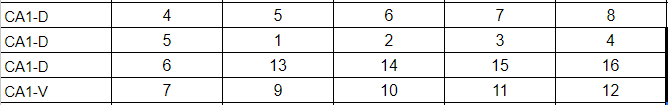

In [ ]:

lentaVector = np.arange(1,16,1)
altaVector = np.arange(30,150,10)
lenta_BandWidth = 2
alta_BandWidth = 10
numbin = 18

phase_prl = [] #d-1
phase_bla = [] #d-2
phase_dhpc = [] #d-3
phase_vhpc = [] #v-1

data_acel = df_acel[(df_acel['animal'] == 'CCM68' ) & (df_acel['condicao'] == 'OF_pre')]['acel']

data_prl = data_teste[5]
mask_prl_pre = generating_masks_parado(data_prl,data_acel,'PRL')
mask_prl_pre = mask_prl_pre['MASK'].values
phase_amp_hist_prl_pre = pac_histogram(data_prl,data_prl,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin,mask_prl_pre)
phase_prl.append(phase_amp_hist_prl_pre)

data_bla = data_teste[1]
mask_bla_pre = generating_masks_parado(data_bla,data_acel,'BLA')
mask_bla_pre = mask_bla_pre['MASK'].values
phase_amp_hist_bla_pre = pac_histogram(data_bla,data_bla,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin,mask_bla_pre)
phase_bla.append(phase_amp_hist_bla_pre)

data_dhpc = data_teste[13]
mask_dhpc_pre = generating_masks_parado(data_dhpc,data_acel,'dHPC')
mask_dhpc_pre = mask_dhpc_pre['MASK'].values
phase_amp_hist_dhpc_pre = pac_histogram(data_dhpc,data_dhpc,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin,mask_dhpc_pre)
phase_dhpc.append(phase_amp_hist_dhpc_pre)

data_vhpc = data_teste[9]
mask_vhpc_pre = generating_masks_parado(data_vhpc,data_acel,'vHPC')
mask_vhpc_pre = mask_vhpc_pre['MASK'].values
phase_amp_hist_vhpc_pre = pac_histogram(data_vhpc,data_vhpc,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin,mask_vhpc_pre)
phase_vhpc.append(phase_amp_hist_vhpc_pre)

In [ ]:
t = np.linspace(0,36,1000)
sine_wave = 2*np.sin(2*np.pi*t*0.055)+8

# extent = [0,720,altaVector[-1]+alta_BandWidth/2,altaVector[0]+alta_BandWidth/2]
extent = [0,720,30,150]

pac_plot = phase_amp_hist_vhpc_pre
vmin = 0.055
vmax = np.percentile(pac_plot, 97.5)


plt.imshow(np.hstack([pac_plot,pac_plot,pac_plot]),interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto')

plt.yticks(ticks = np.arange(0.5,12.5),labels = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.xticks(ticks = np.arange(16,52,3),labels = np.round(np.arange(0,720,60)).astype(int),rotation = 30)
plt.plot(np.linspace(16,52,1000),sine_wave,color = 'white',linewidth = 4)
plt.ylim([0,11])
plt.xlim([16,52])

plt.ylabel('Amp Frequency (Hz)')
plt.xlabel('Theta Phase (deg)')

plt.colorbar()


plt.tight_layout()

In [ ]:
plotfreq = [4, 20]
plotfreq_mask = (psd_frqs>plotfreq[0]) & (psd_frqs<plotfreq[1])
plt.pcolormesh(psd_frqs[plotfreq_mask], np.arange(35), psd[plotfreq_mask].T, cmap='jet')

In [ ]:
len(psd[0])

In [ ]:
plotfreq = [4, 20]
plotfreq_mask = (psd_frqs>plotfreq[0]) & (psd_frqs<plotfreq[1])
plt.pcolormesh(psd_frqs[plotfreq_mask], np.arange(35), psd[plotfreq_mask].T, cmap='jet')

In [ ]:
def bandpass(data, cutfreq, filtorder, sampling_rate):

        fny = sampling_rate/2

        b, a = signal.butter(N = filtorder, Wn=np.array(cutfreq) / fny,
                                         btype='bandpass')
        dataout = signal.filtfilt(b, a, data)

        return dataout

In [ ]:

# def phase_amp_hist(amp,fase_lenta,numbin):

#     position=np.zeros(numbin) # this variable will get the beginning (not the center) of each phase bin (in rads)
#     winsize = 2*np.pi/numbin # bin de fase

#     position = []
#     for j in np.arange(1,numbin+1):
#         position.append(-np.pi+(j-1)*winsize)


#     nbin=numbin
#     mean_amp = []
#     for j in np.arange(0,nbin):
#         boolean_array = np.logical_and(fase_lenta >=  position[j], fase_lenta < position[j]+winsize)
#         I = np.where(boolean_array)[0]
#         mean_amp.append(np.mean(amp[I]))

#     mean_amp = [x for x in mean_amp if str(x) != 'nan']
#     p = mean_amp/np.sum(mean_amp)

#     return(p)


# def pac_histogram(lfp,altaVector,lenta_BandWidth,alta_BandWidth,srate,numbin,mask):

#     amplitude = []

#     AmpFreq= bandpass(np.array(lfp),[30,150],3,1000)

#     analytic_signal_alta = signal.hilbert(AmpFreq)
#     amplitude.append(np.abs(analytic_signal_alta)[mask])


#     PhaseFreq = bandpass(np.array(lfp),[4,18],3,1000)
#     analytic_signal_baixa = signal.hilbert(PhaseFreq)
#     faselenta = np.angle(analytic_signal_baixa)[mask]

#     hist_freqs = []

#     for count_rapida,rapida in enumerate(amplitude):

#         hist_freqs.append(phase_amp_hist(rapida,faselenta,numbin))


#     return(hist_freqs)

In [ ]:
def phase_amp_hist(amp,fase_lenta,numbin):

    position=np.zeros(numbin) # this variable will get the beginning (not the center) of each phase bin (in rads)
    winsize = 2*np.pi/numbin # bin de fase

    position = []
    for j in np.arange(1,numbin+1):
        position.append(-np.pi+(j-1)*winsize)


    nbin=numbin
    mean_amp = []
    for j in np.arange(0,nbin):
        boolean_array = np.logical_and(fase_lenta >=  position[j], fase_lenta < position[j]+winsize)
        I = np.where(boolean_array)[0]
        mean_amp.append(np.mean(amp[I]))

    mean_amp = [x for x in mean_amp if str(x) != 'nan']
    p = mean_amp/np.sum(mean_amp)

    return(p)


def pac_histogram(lfp_amp,lfp_fase,altaVector,lenta_BandWidth,alta_BandWidth,srate,numbin,mask):

    AmpFreqTransformed1 = []

    for ii in altaVector:
        Af1 = ii
        Af2=Af1+alta_BandWidth

        AmpFreq1=eegfilt(lfp_amp,srate,Af1,Af2) # just filtering

        analytic_signal1 = signal.hilbert(AmpFreq1)
        AmpFreqTransformed1.append(np.abs(analytic_signal1)[mask])

    Pf1 = 4
    Pf2 = 18
    PhaseFreq=eegfilt(lfp_fase,srate,Pf1,Pf2)
    analytic_signal = signal.hilbert(PhaseFreq)
    faselenta = np.angle(analytic_signal)[mask]

    hist_freqs = []

    for count_rapida,rapida in enumerate(AmpFreqTransformed1):

        hist_freqs.append(phase_amp_hist(rapida,faselenta,numbin))


    return(hist_freqs)

In [ ]:
def generating_masks_parado(DATA,data_acel,regiao): #ANIMAL PARADO



  # Recuperando dado da acelerometria para definir momentos de atividade

  acel = np.array(data_acel)
  acel = np.diff(acel, axis = 0)
  acel = abs(pd.DataFrame(acel)).rolling(window=1000).mean()

  # array booleano dizendo onde animal mexeu e não mexeu
  parado_bool = np.array(acel <= 0.005 )
  parado_bool = np.append(parado_bool, 0) #aqui foi adicionado um 0 pois a função diff retira um elemento do vetor, assim ele volta ao tamanho original


  index_parado_all = []
  for x in range(len(parado_bool)):
      if parado_bool[x] == True:
        index_parado_all.append(x)


  vector_nan = np.full(len(DATA), np.nan)

  vector_nan[index_parado_all] = DATA[index_parado_all]


  # Essa parte do código irá retirar pedaços muito curtos de dado (menos de 2s)
  groups = find_consecutive_groups(vector_nan)

  for start, end in groups:
      length = end - start
      if length < 2000:
            vector_nan[start:end] = np.nan #transforma pedaços menores que 2s em Nan

  mask = np.where(~np.isnan(vector_nan))[0] #pegando apenas os indices dos valores que não são Nan


  return(pd.DataFrame({'MASK': mask, 'regiao': regiao}))

In [ ]:
lfp = df_full[(df_full['animal'] == 'CCM68') & (df_full['condicao'] == 'OF_pre')]['data_VHPC']
sampling_rate = 1000
theta_fcut = [4, 18]
theta = bandpass(lfp, theta_fcut, 3, 1000)

theta_maxf = 12
theta_peaks = signal.find_peaks(theta, height=0, distance=int(sampling_rate/theta_maxf))[0] #detectando picos para centralizar a janela
#a variavel distance dentro de theta_peaks garante que não vai pegar dois picos de theta muito próximos

In [ ]:
plt.plot(lfp, color='k', lw=2)
plt.plot(theta, color='r', lw=1)
plt.plot(theta_peaks, theta[theta_peaks], lw=0, color='r', marker='^', markersize=8)
plt.xlim(10000,11000)

In [ ]:
def do_ta(time_ref, signal_2trigger, ta_winlen): # função para achar o trigger avaerage (é a média de um sinal centralizado em um evento, nesse caso o evento é o pico de theta)

        time_ref = time_ref[time_ref > ta_winlen//2]
        time_ref = time_ref[time_ref < (len(signal_2trigger) - ta_winlen//2)]
        rel_samples = np.arange(ta_winlen) - ta_winlen//2 # essa variavel vai compor o eixo x

        ta_mat = np.zeros((len(time_ref),ta_winlen))
        for ta_win_i in range(0, len(time_ref)):
                win_samples = rel_samples + time_ref[ta_win_i]
                ta_mat[ta_win_i] = signal_2trigger[win_samples]

        ta = np.mean(ta_mat, axis=0)
        return ta, rel_samples #

ta_winlen = 400

gamma_fcut = [30, 150]
gamma = bandpass(lfp, gamma_fcut, 3, sampling_rate)
gamma_hilb = signal.hilbert(gamma) #usando trasf hilbert para fazer o envelope
gamma_env = np.abs(gamma_hilb)


ta_lfp, rel_samples  = do_ta(theta_peaks, lfp, ta_winlen)
ta_gammaenv, rel_samples_gamma = do_ta(theta_peaks, gamma_env, ta_winlen)


plt.figure(figsize=(5,3))
plt.subplot(2,1,1)
plt.plot(rel_samples, ta_lfp, color='k', lw=2)
plt.grid(True)
plt.subplot(2,1,2)
plt.plot(rel_samples_gamma, ta_gammaenv, color='darkgreen', lw=2)

plt.grid(True)

In [ ]:
time_ref = theta_peaks

signal_2trigger = lfp
ta_winlen = 400

time_ref = time_ref[time_ref > ta_winlen//2]
time_ref = time_ref[time_ref < (len(signal_2trigger) - ta_winlen//2)]

ta_win_i = 3
time_ref[ta_win_i]

rel_samples = np.arange(ta_winlen) - ta_winlen//2
win_samples = rel_samples + time_ref[ta_win_i]

plt.plot(rel_samples,signal_2trigger[win_samples] )

plt.plot(rel_samples, theta[win_samples])
plt.grid(True)

In [ ]:
def wvfilt(lfp,mfreq,sr=1250., w=5, s=1, normwv=True):

        # computing the length of the wavelet for the desired frequency
        wavelen = int(np.round(2*w*s*sr/mfreq))

        # constructs morlet wavelet with given parameters
        wave = signal.morlet(wavelen,w=w,s=s,complete=True)

        # cutting borders
        cumulativeEnvelope = np.cumsum(np.abs(wave))/np.sum(np.abs(wave))
        Cut1 = next(i for (i,val) in enumerate(cumulativeEnvelope[::-1]) if val<=(1./2000))
        Cut2 = Cut1
        Cut1 = len(cumulativeEnvelope)-Cut1-1
        wave = wave[range(Cut1,Cut2)]

        # normalizes wavelet energy
        if normwv:
                wave = wave/(.5*sum(abs(wave)))

        if (len(wave))>len(lfp):
                print('ERROR: input signal needs at least '+str(len(wave))+\
                                                            ' time points for '+str(mfreq)+\
                                                                      'Hz-wavelet convolution')
                return None

        # convolving signal with wavelet
        fsignal = np.convolve(lfp,wave,'same')
        return fsignal


def wvSpect(lfp,freqs,sampling_rate):

        freqs = np.array(freqs).reshape(-1,1)
        tfr = np.zeros((np.size(freqs),len(lfp)),dtype=complex)
        for (fi,f) in enumerate(freqs):
                f = float(f)
                tfr[fi,:] = wvfilt(lfp,f,sampling_rate)

        output = np.abs(tfr).squeeze()

        return output


In [ ]:
frequencies, times, Sxx = spectrogram(data_dhpc, fs=1000, nperseg=1000, noverlap=int(0.9*1000), nfft = 10 * 1000 )

In [ ]:
lfp = df_full[(df_full['animal'] == 'CCM68') & (df_full['condicao'] == 'OF_pre')]['data_DHPC']

In [ ]:
freqs = np.arange(30, 90)

wvspect = wvSpect(lfp,freqs,sampling_rate)

ta_wvspect = do_ta(theta_peaks, wvspect, ta_winlen)



In [ ]:
plt.figure(figsize=(5,3))
plt.pcolormesh(rel_samples,freqs, ta_wvspect[0],cmap='jet')
plt.colorbar()
plt.grid(True)

In [ ]:

lentaVector = np.arange(1,12,1)
altaVector = np.arange(30,150,10)
lenta_BandWidth = 2
alta_BandWidth = 10
numbin = 18

phase_prl = []
phase_bla = []
phase_dhpc = []
phase_vhpc = []

for rato in ratos.keys():


  data_acel = df_acel[(df_acel['animal'] == str(rato) ) & (df_acel['condicao'] == 'OF_pre')]['acel']

  data_prl = df_full[(df_full['animal'] == str(rato)) & (df_full['condicao'] == 'OF_pre')]['data_PRL']
  mask_prl_pre = generating_masks_parado(data_prl,data_acel,'PRL')
  mask_prl_pre = mask_prl_pre['MASK'].values
  phase_amp_hist_prl_pre = pac_histogram(data_prl,data_prl,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin,mask_prl_pre)
  phase_prl.append(phase_amp_hist_prl_pre)

  data_bla = df_full[(df_full['animal'] == str(rato)) & (df_full['condicao'] == 'OF_pre')]['data_BLA']
  mask_bla_pre = generating_masks_parado(data_bla,data_acel,'BLA')
  mask_bla_pre = mask_bla_pre['MASK'].values
  phase_amp_hist_bla_pre = pac_histogram(data_bla,data_bla,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin,mask_bla_pre)
  phase_bla.append(phase_amp_hist_bla_pre)

  data_dhpc = df_full[(df_full['animal'] == str(rato)) & (df_full['condicao'] == 'OF_pre')]['data_DHPC']
  mask_dhpc_pre = generating_masks_parado(data_dhpc,data_acel,'dHPC')
  mask_dhpc_pre = mask_dhpc_pre['MASK'].values
  phase_amp_hist_dhpc_pre = pac_histogram(data_dhpc,data_dhpc,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin,mask_dhpc_pre)
  phase_dhpc.append(phase_amp_hist_dhpc_pre)

  data_vhpc = df_full[(df_full['animal'] == str(rato)) & (df_full['condicao'] == 'OF_pre')]['data_VHPC']
  mask_vhpc_pre = generating_masks_parado(data_vhpc,data_acel,'vHPC')
  mask_vhpc_pre = mask_vhpc_pre['MASK'].values
  phase_amp_hist_vhpc_pre = pac_histogram(data_vhpc,data_vhpc,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin,mask_vhpc_pre)
  phase_vhpc.append(phase_amp_hist_vhpc_pre)

In [ ]:
t = np.linspace(0,36,1000)
sine_wave = 2*np.sin(2*np.pi*t*0.055)+8

# extent = [0,720,altaVector[-1]+alta_BandWidth/2,altaVector[0]+alta_BandWidth/2]
extent = [0,720,30,150]

pac_plot = np.mean(phase_dhpc, axis = 0)
vmin = 0.055
vmax = np.percentile(pac_plot, 97.5)


plt.imshow(np.hstack([pac_plot,pac_plot,pac_plot]),interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto')

plt.yticks(ticks = np.arange(0.5,12.5),labels = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.xticks(ticks = np.arange(16,52,3),labels = np.round(np.arange(0,720,60)).astype(int),rotation = 30)
plt.plot(np.linspace(16,52,1000),sine_wave,color = 'white',linewidth = 4)
plt.ylim([0,11])
plt.xlim([16,52])

plt.ylabel('Amp Frequency (Hz)')
plt.xlabel('Theta Phase (deg)')

plt.colorbar()


plt.tight_layout()

In [ ]:

def activity_versus_imobility( rato, condicao,regiao  ):
  nperseg = 1000
  sampling_rate = 1000

  data = df_full[(df_full['animal'] == str(rato)) & (df_full['condicao'] == str(condicao))][str(regiao)]
  cutfreq = [4,18]

  data_filt = bandpass(data, cutfreq, 3, sampling_rate)

  frequencies, times, Sxx = spectrogram(data_filt, fs=1000, nperseg=1000, noverlap=int(0.9*1000), nfft = 10 * 1000 )

  data_acel = df_acel[(df_acel['animal'] == str(rato)) & (df_acel['condicao'] == str(condicao))]['acel']
  acc = data_acel
  win_size_s = nperseg / sampling_rate
  time_array = np.arange(len(data_filt))/sampling_rate

  win_acc = np.zeros(len(times))

  for win_i in range(0, len(times)):
          win_edges_s = [times[win_i] - win_size_s / 2, times[win_i] + win_size_s / 2]
          tmask = (time_array >= win_edges_s[0]) & (time_array < win_edges_s[1])
          win_acc_ = np.mean(acc.values[tmask])
          win_acc[win_i] = win_acc_

  thrs_high = np.percentile(win_acc, 75)
  mask_acchigh = win_acc > thrs_high
  Sxx_high = np.mean(Sxx[:, mask_acchigh], axis=1)

  thrs_low = np.percentile(win_acc, 25)
  mask_acclow = win_acc < thrs_low
  Sxx_low = np.mean(Sxx[:, mask_acclow], axis=1)

  return frequencies, Sxx_low, Sxx_high


In [ ]:
data1 = df_full[(df_full['animal'] == 'CCM68') & (df_full['condicao'] == 'OF_pre')]['data_DHPC']
data2 = df_full[(df_full['animal'] == 'CCM191') & (df_full['condicao'] == 'OF_pre')]['data_DHPC']

In [ ]:
len(data1)

In [ ]:
f, s_low, s_high = activity_versus_imobility( 'CCM191', 'OF_pre','data_DHPC'  )

In [ ]:
len(data2)

In [ ]:
sxx_low = []
sxx_high = []

for rato in ratos.keys():
  f, s_low, s_high = activity_versus_imobility( str(rato), 'OF_pos','data_DHPC'  )
  sxx_low.append(s_low)
  sxx_high.append(s_high)

  # plt.figure()
  # plt.plot(f, s_low, color='b', label = 'Low activity')
  # plt.plot(f, s_high, color='r', label = 'High activity')
  # plt.xlim(0,20)
  # plt.xticks(np.arange(0, 21, 4))

  # plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
  # plt.title(str(rato), fontweight='bold')
  # plt.legend()
  # plt.xlim(0,20)

In [ ]:
sxx_low = []
sxx_high = []

for rato in ratos.keys():
  f, s_low, s_high = activity_versus_imobility( str(rato), 'OF_pos','data_DHPC'  )
  sxx_low.append(s_low)
  sxx_high.append(s_high)


s_low = np.mean(sxx_low, 0)
s_high = np.mean(sxx_high, 0)

plt.figure()
plt.plot(f, s_low, color='b', label = 'Low activity')
plt.plot(f, s_high, color='r', label = 'High activity')
plt.xlim(0,20)
plt.xticks(np.arange(0, 21, 4))

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.title(str(rato), fontweight='bold')
plt.legend()
plt.xlim(0,20)

In [ ]:
s_low = np.mean(sxx_low, 0)
s_high = np.mean(sxx_high, 0)

plt.figure()
plt.plot(f, s_low, color='b', label = 'Low activity')
plt.plot(f, s_high, color='r', label = 'High activity')
plt.xlim(0,20)
plt.xticks(np.arange(0, 21, 4))

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.title(str(rato), fontweight='bold')
plt.legend()
plt.xlim(0,20)

In [ ]:
F_ANIMALS_PRE = []
S_LOW_ANIMALS_PRE = []
S_HIGH_ANIMALS_PRE = []

for rato in ratos.keys():
  f, s_low, s_high = activity_versus_imobility( str(rato), 'OF_pre','data_DHPC'  )
  F_ANIMALS_PRE.append(f)
  S_LOW_ANIMALS_PRE.append(s_low)
  S_HIGH_ANIMALS_PRE.append(s_high)



In [ ]:
s_low = np.mean(S_LOW_ANIMALS_PRE, axis = 0)
s_high = np.mean(S_HIGH_ANIMALS_PRE, axis = 0)
f =  np.mean(F_ANIMALS_PRE, axis = 0)

In [ ]:

plt.plot(f, s_low, color='b', label = 'Low activity')
plt.plot(f, s_high, color='r', label = 'High activity')
plt.xlim(0,20)
plt.xticks(np.arange(0, 21, 4))

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.title('Low x High activity PSD - PRE STRESS', fontweight='bold')
plt.legend()
plt.xlim(0,20)

In [ ]:

plt.plot(frequencies, Sxx_low, color='b', label = 'Low activity')
plt.plot(frequencies, Sxx_high, color='r', label = 'High activity')
plt.xlim(0,20)
plt.xticks(np.arange(0, 21, 4))

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.title('Low x High activity PSD - PRE STRESS', fontweight='bold')
plt.legend()
plt.xlim(0,20)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes



fig, ax_main = plt.subplots(figsize=(8, 6))

# Configure o subplot principal para o espectrograma
plt.pcolormesh(times, frequencies[fmask], Sxx[fmask], cmap='jet', vmin=0, vmax=20000)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.xlim(0, 300)

# Crie um subplot menor para o gráfico de aceleração dentro do subplot principal
axins = inset_axes(ax_main, width="30%", height="30%", loc='upper right')
axins.plot(acel, color='k')
axins.set_ylabel('Acceleration (m/s²)')
axins.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
axins.set_xlim(0, 300000)

# Remova os ticks do eixo x do subplot principal
ax_main.set_xticks([])

# Resto do seu código para personalizar e mostrar a figura
plt.show()


In [ ]:

fmax = 22
fmask = frequencies < fmax

plt.pcolormesh(times, frequencies[fmask], Sxx[fmask], cmap='jet')

plt.ylim(0,20)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import pandas as pd



fig, ax_main = plt.subplots(figsize=(8, 6))

# Configure o subplot principal
x = df_welch_pre_escap['f']
y_prl = df_welch_pre_escap['mean_power_prl']
std = np.std(y_prl) / np.sqrt(3)  # Cálculo do desvio padrão

x_pos = df_welch_pos_escap['f']
y_pos_prl = df_welch_pos_escap['mean_power_prl']
std_pos = np.std(y_pos_prl) / np.sqrt(3)

ax_main.plot(x, y_prl, linewidth=1.5, color='black', label='PRE STRESS - ESCAPABLE')
ax_main.fill_between(x, y_prl - std, y_prl + std, color='gray', alpha=0.3, edgecolor=None)

ax_main.plot(x_pos, y_pos_prl, linewidth=1.5, color='darkred', label='POS STRESS - ESCAPABLE')
ax_main.fill_between(x_pos, y_pos_prl - std_pos, y_pos_prl + std_pos, color='darkred', alpha=0.1, edgecolor=None)

x_inesc = df_welch_pre_inescap['f']
y_prl_inesc = df_welch_pre_inescap['mean_power_prl']
std_inesc = np.std(y_prl_inesc) / np.sqrt(3)

x_pos_inesc = df_welch_pos_inescap['f']
y_pos_prl_inesc = df_welch_pos_inescap['mean_power_prl']
std_pos_inesc = np.std(y_pos_prl_inesc) / np.sqrt(3)

ax_main.plot(x_inesc, y_prl_inesc, linewidth=1.5, linestyle='--', color='black', label='PRE STRESS - INESCAPABLE')
ax_main.fill_between(x_inesc, y_prl_inesc - std_inesc, y_prl_inesc + std_inesc, color='gray', alpha=0.3, edgecolor=None)

ax_main.plot(x_pos_inesc, y_pos_prl_inesc, linewidth=1.5, linestyle='--', color='darkred', label='POS STRESS - INESCAPABLE')
ax_main.fill_between(x_pos_inesc, y_pos_prl_inesc - std_pos_inesc, y_pos_prl_inesc + std_pos_inesc, color='darkred', alpha=0.1, edgecolor=None)

ax_main.grid(False)
ax_main.legend(fontsize=11, loc='lower left', frameon=False)
ax_main.set_xlabel('Frequency (Hz)')
ax_main.set_ylabel('Power Ratio (a.u.)')
ax_main.set_xlim(0, 20)
ax_main.set_xticks(np.arange(0, 21, 4))
ax_main.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax_main.set_title('PRL', fontweight='bold', pad=8, fontsize=12)
ax_main.spines['top'].set_visible(False)
ax_main.spines['right'].set_visible(False)

# Inserir subplot no canto superior direito

axins = inset_axes(ax_main, width="35%", height="40%", loc='upper right',
                   bbox_to_anchor=(0.01, 0.001, 0.95, 0.95),  # x0, y0, largura, altura
                   bbox_transform=ax_main.transAxes)

sns.barplot(data=df_barplot_theta_PRL, x="GRUPO", y="PSD", hue="CONDICAO",
            palette=['grey', 'darkred'], alpha=0.8, ax=axins)
sns.swarmplot(data=df_swarmplot_theta_PRL, x="GRUPO", y="PSD", hue="CONDICAO",
              color="k", size=7, dodge=True, alpha=0.7, ax=axins, legend = False)
axins.legend(loc='upper left', bbox_to_anchor=(0.2, 1.3), fontsize='small', title='', title_fontsize='medium', ncol=2)

axins.spines['top'].set_visible(False)
axins.spines['right'].set_visible(False)
axins.set_ylabel('Theta Power Ratio (a.u.)', fontsize = 10)
axins.set_xlabel('')
axins.tick_params(axis='x', labelsize='small')
axins.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

plt.show()

